数据维度: (1024, 1280)
数据类型: uint16
数据范围: [28, 1023]
DataFrame创建完成，形状: (1310720, 4)
   x  y  intensity  pixel_index
0  0  0         51            0
1  1  0         56            1
2  2  0         57            2
3  3  0         61            3
4  4  0         51            4


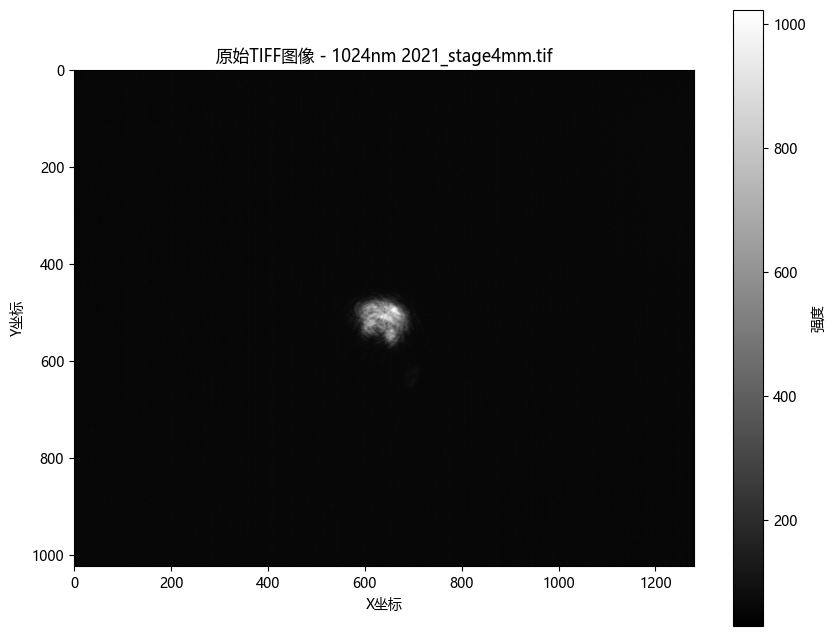


=== 光谱TIFF处理菜单 ===
1. 切割数据
2. 光谱分析
3. 可视化分析结果
4. 保存结果
5. 查看数据块列表
0. 退出
分析结果已保存到: spectral_analysis_1024nm 2021_stage4mm.tif.pkl

=== 光谱TIFF处理菜单 ===
1. 切割数据
2. 光谱分析
3. 可视化分析结果
4. 保存结果
5. 查看数据块列表
0. 退出
分析结果已保存到: spectral_analysis_1024nm 2021_stage4mm.tif.pkl

=== 光谱TIFF处理菜单 ===
1. 切割数据
2. 光谱分析
3. 可视化分析结果
4. 保存结果
5. 查看数据块列表
0. 退出


'\n类的关键概念总结：\n\n1. 实例属性 (Instance Attributes):\n   - self.tiff_data, self.data_blocks, self.processed_spectra 等\n   - 每个实例都有自己独立的属性副本\n   - 通过 self.attribute_name 访问和修改\n\n2. 实例方法 (Instance Methods):\n   - 第一个参数必须是 self\n   - 通过 self 访问实例属性和调用其他方法\n   - 调用方式：instance.method_name()\n\n3. 数据封装 (Data Encapsulation):\n   - 相关数据和操作数据的方法组织在一起\n   - 外部代码通过方法接口访问数据，而不直接操作内部数据\n\n4. 状态保持 (State Persistence):\n   - 对象在整个生命周期中保持状态\n   - 方法调用之间可以共享数据\n\n5. 方法协作 (Method Collaboration):\n   - 不同方法可以相互调用\n   - 每个方法专注于特定功能\n   - 通过组合实现复杂功能\n\n这种设计模式特别适合科学数据分析，因为：\n- 数据处理通常包含多个步骤\n- 每个步骤的结果需要被后续步骤使用\n- 用户可能需要反复查看和分析中间结果\n- 整个分析流程需要保持数据的一致性\n'

In [6]:
# TIFF光谱数据分析程序 - 详细注释版本
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from tkinter import Tk, filedialog, messagebox, simpledialog
import tifffile
from scipy import signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import pickle
import os

class SpectralTiffProcessor:
    """
    光谱TIFF处理器类
    
    这个类的目的：
    - 专门用于处理光谱仪生成的2D TIFF图像
    - 将图像数据转换为可分析的光谱数据
    - 进行峰值检测和光谱特征分析
    
    类的优势：
    1. 封装性：将相关的数据和方法组织在一起
    2. 状态保持：可以在不同方法间保持数据状态
    3. 代码复用：创建多个实例处理不同的文件
    4. 易于扩展：可以轻松添加新的分析方法
    """
    plt.rcParams['font.family'] = 'Microsoft YaHei'      # 默认字体设置为 Yahei

    def __init__(self):
        """
        初始化方法 - 类的构造函数
        
        当你创建类的实例时（如 processor = SpectralTiffProcessor()），
        这个方法会自动被调用来设置初始状态
        
        self参数说明：
        - self代表类的实例本身
        - 通过self可以访问和修改实例的属性
        - 每个实例都有自己独立的属性副本
        """
        # 实例属性 - 每个实例都有自己的这些变量
        self.tiff_data = None           # 存储加载的TIFF图像数据（numpy数组）
        self.dataframe = None           # 存储转换后的DataFrame格式数据
        self.data_blocks = {}           # 字典，存储切割后的数据块
        self.processed_spectra = {}     # 字典，存储光谱分析结果
        self.file_path = None           # 存储当前处理的文件路径
        
    def load_tiff_file(self):
        """
        加载TIFF文件的方法
        
        方法说明：
        - 实例方法：必须通过实例调用 (processor.load_tiff_file())
        - 返回值：布尔值，表示是否成功加载
        - 修改实例状态：更新self.tiff_data和self.file_path
        """
        # 创建文件选择对话框
        root = Tk()
        root.withdraw()  # 隐藏主窗口，只显示对话框
        
        # 使用tkinter的文件对话框选择TIFF文件
        self.file_path = filedialog.askopenfilename(
            title="选择TIFF文件", 
            filetypes=[("TIFF文件", "*.tif;*.tiff")]
        )
        
        # 检查用户是否选择了文件
        if not self.file_path:
            print("未选择文件")
            return False
            
        try:
            # 使用tifffile库读取TIFF文件
            self.tiff_data = tifffile.imread(self.file_path)
            
            # 数据预处理：确保数据是2D的
            if len(self.tiff_data.shape) > 2:
                print(f"原始数据维度: {self.tiff_data.shape}")
                
                # 如果是RGB或RGBA图像（3或4通道）
                if len(self.tiff_data.shape) == 3 and self.tiff_data.shape[2] in [3, 4]:
                    # 取RGB通道的平均值转为灰度图
                    self.tiff_data = np.mean(self.tiff_data[:, :, :3], axis=2).astype(self.tiff_data.dtype)
                else:
                    # 如果是其他多维数据，取第一层
                    self.tiff_data = self.tiff_data[0]
                print(f"转换后维度: {self.tiff_data.shape}")
            
            # 打印数据信息
            print(f"数据维度: {self.tiff_data.shape}")
            print(f"数据类型: {self.tiff_data.dtype}")
            print(f"数据范围: [{np.min(self.tiff_data)}, {np.max(self.tiff_data)}]")
            
            return True
            
        except Exception as e:
            print(f"加载TIFF文件时出错: {e}")
            return False
    
    def convert_to_dataframe(self):
        """
        将2D图像数据转换为DataFrame格式
        
        为什么要转换：
        - DataFrame更适合表格化数据分析
        - 可以轻松进行数据筛选和统计
        - 便于后续的数据处理和可视化
        
        转换逻辑：
        - 将每个像素作为一行数据
        - 包含x坐标、y坐标、强度值、像素索引
        """
        # 检查是否已加载数据
        if self.tiff_data is None:
            print("请先加载TIFF文件")
            return None
            
        height, width = self.tiff_data.shape
        
        # 创建坐标网格
        # meshgrid创建坐标矩阵：x_coords包含每个像素的x坐标，y_coords包含y坐标
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        
        # 将2D数据展平为1D，准备创建DataFrame
        df_data = {
            'x': x_coords.flatten(),           # x坐标列
            'y': y_coords.flatten(),           # y坐标列
            'intensity': self.tiff_data.flatten(),  # 强度值列
            'pixel_index': np.arange(height * width)  # 像素索引列
        }
        
        # 创建DataFrame并存储为实例属性
        self.dataframe = pd.DataFrame(df_data)
        print(f"DataFrame创建完成，形状: {self.dataframe.shape}")
        print(self.dataframe.head())  # 显示前5行数据
        
        return self.dataframe
    
    def slice_data(self, axis='x', start=0, end=None, step_size=1, sum_perpendicular=False):
        """
        数据切割方法 - 将图像按指定方向切割成多个数据块
        
        参数说明：
        - axis: 切割方向 ('x' 或 'y')
        - start: 起始坐标
        - end: 结束坐标 (None表示到边界)
        - step_size: 每块的大小
        - sum_perpendicular: 是否沿垂直方向求和降维
        
        为什么要切割：
        - 光谱仪数据通常一个维度是空间位置，另一个是波长
        - 切割可以提取不同位置的光谱数据
        - 便于逐段分析光谱特征
        """
        if self.tiff_data is None:
            print("请先加载TIFF文件")
            return None
            
        height, width = self.tiff_data.shape
        
        # 根据切割轴确定最大坐标
        if axis == 'x':
            max_coord = width
            if end is None:
                end = width
        else:  # axis == 'y'
            max_coord = height
            if end is None:
                end = height
                
        # 确保坐标在有效范围内
        start = max(0, min(start, max_coord - 1))
        end = max(start + 1, min(end, max_coord))
        
        # 计算可以完整切割的块数
        total_length = end - start
        num_blocks = total_length // step_size
        
        print(f"沿{axis}轴切割，从{start}到{end}，步长{step_size}")
        print(f"总共可切割{num_blocks}块")
        
        # 字典存储切割结果
        blocks = {}
        
        # 循环切割数据
        for i in range(num_blocks):
            if axis == 'x':
                # 沿x轴切割：固定x范围，包含所有y
                block_start = start + i * step_size
                block_end = start + (i + 1) * step_size
                block_data = self.tiff_data[:, block_start:block_end]  # [所有行, x范围]
                
                if sum_perpendicular:
                    # 沿y轴求和，将2D数据降为1D
                    block_data = np.sum(block_data, axis=0)
            else:  # axis == 'y'
                # 沿y轴切割：固定y范围，包含所有x
                block_start = start + i * step_size
                block_end = start + (i + 1) * step_size
                block_data = self.tiff_data[block_start:block_end, :]  # [y范围, 所有列]
                
                if sum_perpendicular:
                    # 沿x轴求和，将2D数据降为1D
                    block_data = np.sum(block_data, axis=1)
            
            # 创建数据块信息字典
            block_name = f"block_{axis}_{i:03d}"  # 格式化名称，如block_x_001
            blocks[block_name] = {
                'data': block_data,           # 实际数据
                'axis': axis,                 # 切割轴
                'start': block_start,         # 起始位置
                'end': block_end,             # 结束位置
                'summed': sum_perpendicular,  # 是否已降维
                'shape': block_data.shape     # 数据形状
            }
        
        # 更新实例的数据块字典
        self.data_blocks.update(blocks)
        print(f"切割完成，共{len(blocks)}个数据块")
        
        return blocks
    
    def gaussian_func(self, x, amplitude, center, sigma, offset):
        """
        高斯函数 - 用于峰值拟合
        
        数学公式：f(x) = A * exp(-((x-μ)²)/(2σ²)) + C
        
        参数：
        - amplitude (A): 峰值高度
        - center (μ): 峰值中心位置
        - sigma (σ): 标准差，控制峰宽
        - offset (C): 基线偏移
        """
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + offset
    
    def lorentzian_func(self, x, amplitude, center, gamma, offset):
        """
        洛伦兹函数 - 用于峰值拟合
        
        数学公式：f(x) = A * γ² / ((x-x₀)² + γ²) + C
        
        参数：
        - amplitude (A): 峰值高度
        - center (x₀): 峰值中心位置  
        - gamma (γ): 半高宽的一半
        - offset (C): 基线偏移
        
        洛伦兹峰通常更适合某些物理现象（如光谱线型）
        """
        return amplitude * gamma**2 / ((x - center)**2 + gamma**2) + offset
    
    def find_peaks_and_analyze(self, spectrum, x_axis=None, block_name="spectrum"):
        """
        光谱峰值检测和分析 - 类的核心分析方法
        
        参数：
        - spectrum: 1D光谱数据
        - x_axis: x轴坐标（如波长），默认使用索引
        - block_name: 数据块名称，用于结果存储
        
        分析内容：
        1. 噪声滤波
        2. 峰值检测
        3. 峰宽测量 (FWHM, 1/e宽度)
        4. 高斯和洛伦兹拟合
        5. 峰面积计算
        6. 信噪比计算
        """
        # 默认x轴为索引
        if x_axis is None:
            x_axis = np.arange(len(spectrum))
        
        # 1. 高斯滤波降噪
        # sigma=1.0 控制平滑程度，值越大越平滑
        smoothed_spectrum = gaussian_filter1d(spectrum, sigma=1.0)
        
        # 2. 使用scipy的find_peaks函数寻找峰值
        peaks, properties = signal.find_peaks(
            smoothed_spectrum, 
            height=np.max(smoothed_spectrum) * 0.1,    # 峰高至少是最大值的10%
            distance=5,                                # 峰之间的最小距离（像素）
            prominence=np.max(smoothed_spectrum) * 0.05 # 峰的突出度（相对于周围的高度差）
        )
        
        # 存储每个峰的分析结果
        peak_analysis = {}
        
        # 3. 对每个检测到的峰进行详细分析
        for i, peak_idx in enumerate(peaks):
            peak_x = x_axis[peak_idx]         # 峰的x坐标
            peak_y = smoothed_spectrum[peak_idx]  # 峰的强度
            
            # 4. 计算半高宽(FWHM - Full Width at Half Maximum)
            half_max = peak_y / 2             # 半高度
            one_e_height = peak_y / np.e      # 1/e高度
            
            # 寻找半高宽的左右边界
            left_idx = peak_idx
            right_idx = peak_idx
            
            # 向左寻找半高点
            while left_idx > 0 and smoothed_spectrum[left_idx] > half_max:
                left_idx -= 1
            
            # 向右寻找半高点
            while right_idx < len(smoothed_spectrum) - 1 and smoothed_spectrum[right_idx] > half_max:
                right_idx += 1
            
            # 使用线性插值获得更精确的半高宽边界
            if left_idx < peak_idx:
                left_x = np.interp(half_max, 
                                 [smoothed_spectrum[left_idx], smoothed_spectrum[left_idx + 1]],
                                 [x_axis[left_idx], x_axis[left_idx + 1]])
            else:
                left_x = x_axis[left_idx]
                
            if right_idx > peak_idx:
                right_x = np.interp(half_max,
                                  [smoothed_spectrum[right_idx - 1], smoothed_spectrum[right_idx]],
                                  [x_axis[right_idx - 1], x_axis[right_idx]])
            else:
                right_x = x_axis[right_idx]
            
            fwhm = right_x - left_x  # 半高宽
            
            # 5. 计算1/e宽度（另一种峰宽度量方式）
            left_1e_idx = peak_idx
            right_1e_idx = peak_idx
            
            # 寻找1/e高度的边界
            while left_1e_idx > 0 and smoothed_spectrum[left_1e_idx] > one_e_height:
                left_1e_idx -= 1
            while right_1e_idx < len(smoothed_spectrum) - 1 and smoothed_spectrum[right_1e_idx] > one_e_height:
                right_1e_idx += 1
                
            # 插值计算1/e宽度
            if left_1e_idx < peak_idx:
                left_1e_x = np.interp(one_e_height,
                                    [smoothed_spectrum[left_1e_idx], smoothed_spectrum[left_1e_idx + 1]],
                                    [x_axis[left_1e_idx], x_axis[left_1e_idx + 1]])
            else:
                left_1e_x = x_axis[left_1e_idx]
                
            if right_1e_idx > peak_idx:
                right_1e_x = np.interp(one_e_height,
                                     [smoothed_spectrum[right_1e_idx - 1], smoothed_spectrum[right_1e_idx]],
                                     [x_axis[right_1e_idx - 1], x_axis[right_1e_idx]])
            else:
                right_1e_x = x_axis[right_1e_idx]
                
            width_1e = right_1e_x - left_1e_x  # 1/e宽度
            
            # 6. 函数拟合（高斯和洛伦兹）
            try:
                # 选择峰周围的数据进行拟合
                fit_range = max(10, int(fwhm * 2)) if fwhm > 0 else 10
                fit_start = max(0, peak_idx - fit_range)
                fit_end = min(len(spectrum), peak_idx + fit_range)
                
                x_fit = x_axis[fit_start:fit_end]
                y_fit = smoothed_spectrum[fit_start:fit_end]
                
                # 高斯拟合
                # 初始参数估计：[振幅, 中心, sigma, 偏移]
                p0 = [peak_y, peak_x, fwhm/2.355, np.min(y_fit)]
                popt_gauss, _ = curve_fit(self.gaussian_func, x_fit, y_fit, p0=p0, maxfev=1000)
                fitted_fwhm_gauss = 2.355 * abs(popt_gauss[2])  # 高斯FWHM = 2.355 * sigma
                
                # 洛伦兹拟合
                # 初始参数估计：[振幅, 中心, gamma, 偏移]
                p0_lor = [peak_y, peak_x, fwhm/2, np.min(y_fit)]
                popt_lor, _ = curve_fit(self.lorentzian_func, x_fit, y_fit, p0=p0_lor, maxfev=1000)
                fitted_fwhm_lor = 2 * abs(popt_lor[2])  # 洛伦兹FWHM = 2 * gamma
                
            except:
                # 拟合失败时设为None
                popt_gauss = None
                popt_lor = None
                fitted_fwhm_gauss = None
                fitted_fwhm_lor = None
            
            # 7. 计算峰面积（梯形积分法）
            peak_area = np.trapz(smoothed_spectrum[left_idx:right_idx+1], 
                               x_axis[left_idx:right_idx+1])
            
            # 8. 计算信噪比 (Signal-to-Noise Ratio)
            # 使用光谱前50个点的标准差作为噪声水平估计
            noise_level = np.std(smoothed_spectrum[:min(50, len(smoothed_spectrum))])
            snr = peak_y / noise_level if noise_level > 0 else float('inf')
            
            # 9. 整理峰值信息
            peak_info = {
                'peak_index': peak_idx,                    # 峰值索引
                'peak_position': peak_x,                   # 峰值位置
                'peak_intensity': peak_y,                  # 峰值强度
                'fwhm_measured': fwhm,                     # 测量的半高宽
                'width_1e': width_1e,                      # 1/e宽度
                'fwhm_gaussian_fit': fitted_fwhm_gauss,    # 高斯拟合的半高宽
                'fwhm_lorentzian_fit': fitted_fwhm_lor,    # 洛伦兹拟合的半高宽
                'gaussian_params': popt_gauss,             # 高斯拟合参数
                'lorentzian_params': popt_lor,             # 洛伦兹拟合参数
                'peak_area': peak_area,                    # 峰面积
                'snr': snr,                               # 信噪比
                'prominence': properties['prominences'][i] if i < len(properties['prominences']) else None
            }
            
            # 将峰值信息添加到分析结果中
            peak_analysis[f'peak_{i+1}'] = peak_info
        
        # 10. 整理完整的分析结果
        analysis_result = {
            'original_spectrum': spectrum,           # 原始光谱
            'smoothed_spectrum': smoothed_spectrum,  # 平滑后的光谱
            'x_axis': x_axis,                       # x轴数据
            'peaks': peak_analysis,                 # 峰值分析结果
            'num_peaks': len(peaks)                 # 峰值数量
        }
        
        # 将结果存储到实例属性中
        self.processed_spectra[block_name] = analysis_result
        
        return analysis_result
    
    def visualize_spectrum_analysis(self, block_name):
        """
        可视化光谱分析结果
        
        生成两个子图：
        1. 上图：原始光谱、平滑光谱和峰值标记
        2. 下图：峰宽度比较柱状图
        """
        # 检查分析结果是否存在
        if block_name not in self.processed_spectra:
            print(f"未找到数据块 {block_name} 的分析结果")
            return
            
        result = self.processed_spectra[block_name]
        
        # 创建包含两个子图的图形
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # 上图：光谱图
        ax1.plot(result['x_axis'], result['original_spectrum'], 'lightblue', alpha=0.7, label='原始光谱')
        ax1.plot(result['x_axis'], result['smoothed_spectrum'], 'blue', linewidth=2, label='平滑光谱')
        
        # 标记检测到的峰值
        for peak_name, peak_info in result['peaks'].items():
            ax1.plot(peak_info['peak_position'], peak_info['peak_intensity'], 'ro', markersize=8)
            ax1.annotate(f"{peak_name}\n位置: {peak_info['peak_position']:.2f}", 
                        (peak_info['peak_position'], peak_info['peak_intensity']),
                        xytext=(10, 10), textcoords='offset points', fontsize=8)
        
        ax1.set_title(f'光谱分析 - {block_name}')
        ax1.set_xlabel('位置/波长')
        ax1.set_ylabel('强度')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 下图：峰宽度比较
        if result['peaks']:
            peak_names = list(result['peaks'].keys())
            positions = [result['peaks'][name]['peak_position'] for name in peak_names]
            fwhms = [result['peaks'][name]['fwhm_measured'] for name in peak_names]
            width_1es = [result['peaks'][name]['width_1e'] for name in peak_names]
            
            x_pos = np.arange(len(peak_names))
            width = 0.35
            
            # 并排柱状图比较不同的宽度测量方法
            ax2.bar(x_pos - width/2, fwhms, width, label='FWHM', alpha=0.8)
            ax2.bar(x_pos + width/2, width_1es, width, label='1/e宽度', alpha=0.8)
            
            ax2.set_xlabel('峰值')
            ax2.set_ylabel('宽度')
            ax2.set_title('峰值宽度比较')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(peak_names, rotation=45)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印详细的数值分析结果
        print(f"\n=== {block_name} 光谱分析结果 ===")
        for peak_name, peak_info in result['peaks'].items():
            print(f"\n{peak_name}:")
            print(f"  位置: {peak_info['peak_position']:.3f}")
            print(f"  强度: {peak_info['peak_intensity']:.3f}")
            print(f"  FWHM (测量): {peak_info['fwhm_measured']:.3f}")
            print(f"  1/e宽度: {peak_info['width_1e']:.3f}")
            if peak_info['fwhm_gaussian_fit']:
                print(f"  FWHM (高斯拟合): {peak_info['fwhm_gaussian_fit']:.3f}")
            if peak_info['fwhm_lorentzian_fit']:
                print(f"  FWHM (洛伦兹拟合): {peak_info['fwhm_lorentzian_fit']:.3f}")
            print(f"  信噪比: {peak_info['snr']:.2f}")
    
    def save_analysis_results(self, filename=None):
        """
        保存分析结果到文件
        
        使用pickle格式保存，可以完整保存Python对象
        包括数据块和所有分析结果
        """
        if filename is None:
            # 如果没有指定文件名，根据原文件名生成
            filename = f"spectral_analysis_{os.path.basename(self.file_path)}.pkl"
        
        # 准备要保存的数据
        save_data = {
            'data_blocks': self.data_blocks,           # 切割的数据块
            'processed_spectra': self.processed_spectra, # 光谱分析结果
            'file_info': {                            # 文件信息
                'original_file': self.file_path,
                'data_shape': self.tiff_data.shape if self.tiff_data is not None else None
            }
        }
        
        # 使用pickle保存
        with open(filename, 'wb') as f:
            pickle.dump(save_data, f)
        
        print(f"分析结果已保存到: {filename}")
    
    def interactive_interface(self):
        """
        交互式用户界面 - 程序的主入口点
        
        提供菜单驱动的用户界面，让用户可以：
        1. 加载文件
        2. 切割数据
        3. 进行光谱分析
        4. 可视化结果
        5. 保存结果
        """
        # 首先加载TIFF文件
        if not self.load_tiff_file():
            return
            
        # 转换为DataFrame格式
        self.convert_to_dataframe()
        
        # 显示原始图像
        self.visualize_original()
        
        # 主菜单循环
        while True:
            print("\n=== 光谱TIFF处理菜单 ===")
            print("1. 切割数据")
            print("2. 光谱分析")
            print("3. 可视化分析结果")
            print("4. 保存结果")
            print("5. 查看数据块列表")
            print("0. 退出")
            
            choice = input("请选择操作 (0-5): ").strip()
            
            if choice == '0':
                break
            elif choice == '1':
                self.interactive_slice()
            elif choice == '2':
                self.interactive_analysis()
            elif choice == '3':
                self.interactive_visualization()
            elif choice == '4':
                self.save_analysis_results()
            elif choice == '5':
                self.list_data_blocks()
    
    def visualize_original(self):
        """
        显示原始TIFF图像的方法
        
        类方法解说：
        - 这是一个实例方法（通过 self 参数访问实例属性）
        - self.tiff_data: 访问当前实例存储的TIFF图像数据
        - self.file_path: 访问当前实例存储的文件路径
        
        方法的作用：
        - 将加载的2D TIFF数据以灰度图像的形式显示
        - 提供颜色条显示强度范围
        - 设置合适的标题和坐标轴标签
        """
        # 检查实例是否已加载数据
        # self.tiff_data 是实例属性，如果为None说明没有加载数据
        if self.tiff_data is None:
            return  # 直接返回，不执行后续代码
            
        # 创建matplotlib图形和坐标轴对象
        # figsize=(10, 8) 设置图形大小为10x8英寸
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 使用imshow显示2D数组作为图像
        # self.tiff_data: 访问实例的图像数据
        # cmap='gray': 使用灰度颜色映射
        img = ax.imshow(self.tiff_data, cmap='gray')
        
        # 添加颜色条，显示强度值对应的颜色
        plt.colorbar(img, ax=ax, label='强度')
        
        # 设置图像标题
        # os.path.basename(self.file_path): 从完整路径中提取文件名
        # self.file_path: 访问实例存储的文件路径
        ax.set_title(f'原始TIFF图像 - {os.path.basename(self.file_path)}')
        ax.set_xlabel('X坐标')
        ax.set_ylabel('Y坐标')
        
        # 显示图形
        plt.show()
    
    def interactive_slice(self):
        """
        交互式数据切割方法
        
        类方法特点：
        - 通过 self 访问实例的 tiff_data 属性获取图像尺寸
        - 调用同一实例的 slice_data 方法进行数据切割
        - 方法间通过 self 共享数据状态
        
        交互流程：
        1. 显示当前图像尺寸
        2. 让用户选择切割参数
        3. 调用 slice_data 方法执行切割
        """
        # 访问实例属性获取图像尺寸信息
        # self.tiff_data.shape: 当前实例存储的图像数据的形状 (高度, 宽度)
        print(f"当前图像尺寸: {self.tiff_data.shape}")
        
        # 获取用户输入的切割轴选择
        axis = input("选择切割轴 (x/y): ").strip().lower()
        if axis not in ['x', 'y']:
            print("无效选择，使用默认x轴")
            axis = 'x'
            
        # 根据切割轴确定最大坐标值
        # self.tiff_data.shape[1]: 图像宽度（x轴最大值）
        # self.tiff_data.shape[0]: 图像高度（y轴最大值）
        max_coord = self.tiff_data.shape[1] if axis == 'x' else self.tiff_data.shape[0]
        
        try:
            # 获取用户输入的切割参数
            start = int(input(f"起始坐标 (0-{max_coord-1}): "))
            end = int(input(f"结束坐标 (1-{max_coord}): "))
            step_size = int(input("步长: "))
            sum_choice = input("是否沿垂直方向求和降维? (y/n): ").strip().lower()
            sum_perpendicular = sum_choice == 'y'
            
            # 调用同一实例的 slice_data 方法
            # 这是类方法的优势：可以直接调用同一对象的其他方法
            # 所有参数都会传递给 slice_data 方法
            self.slice_data(axis, start, end, step_size, sum_perpendicular)
            
        except ValueError:
            # 处理用户输入无效数字的情况
            print("输入无效，请输入数字")
    
    def interactive_analysis(self):
        """
        交互式光谱分析方法
        
        类的状态管理：
        - 检查 self.data_blocks: 实例的数据块字典
        - 访问 self.data_blocks[block_name]: 获取特定数据块
        - 调用 self.find_peaks_and_analyze(): 执行光谱分析
        
        这个方法展示了类的优势：
        1. 状态持久性：data_blocks在方法调用间保持
        2. 方法协作：多个方法协同工作处理同一份数据
        3. 数据封装：用户不需要直接操作复杂的数据结构
        """
        # 检查实例是否有可用的数据块
        # self.data_blocks 是实例属性，存储切割后的数据块
        if not self.data_blocks:
            print("没有可用的数据块，请先切割数据")
            return
            
        # 调用实例方法显示数据块列表
        # 这展示了类方法间的协作关系
        self.list_data_blocks()
        
        # 获取用户选择的数据块名称
        block_name = input("选择要分析的数据块名称: ").strip()
        
        # 检查用户输入的数据块是否存在
        # 通过字典键检查：block_name in self.data_blocks
        if block_name not in self.data_blocks:
            print("数据块不存在")
            return
            
        # 从实例的数据块字典中获取特定数据块
        # self.data_blocks 是字典，存储多个数据块
        block = self.data_blocks[block_name]
        
        # 处理不同维度的数据
        # block['data'] 是存储的实际数据数组
        # block['summed'] 是布尔值，表示是否已经降维
        if len(block['data'].shape) == 2:  # 如果是2D数据
            if not block['summed']:  # 如果还没有降维
                print("2D数据需要降维，沿哪个方向求和?")
                sum_axis = input("输入0(沿行求和)或1(沿列求和): ").strip()
                try:
                    sum_axis = int(sum_axis)
                    # numpy的sum方法，axis=0沿行求和，axis=1沿列求和
                    spectrum = np.sum(block['data'], axis=sum_axis)
                except:
                    print("输入无效，使用默认沿行求和")
                    spectrum = np.sum(block['data'], axis=0)
            else:
                # 如果已经降维，直接使用
                spectrum = block['data']
        else:
            # 如果是1D数据，直接使用
            spectrum = block['data']
        
        # 调用实例的光谱分析方法
        # 这是类方法协作的典型例子：
        # - interactive_analysis 负责用户交互和数据准备
        # - find_peaks_and_analyze 负责具体的科学分析
        # - 分析结果会存储到 self.processed_spectra 中
        self.find_peaks_and_analyze(spectrum, block_name=block_name)
        print(f"光谱分析完成: {block_name}")
    
    def interactive_visualization(self):
        """
        交互式可视化方法
        
        类属性访问：
        - self.processed_spectra: 存储光谱分析结果的字典
        - self.processed_spectra.keys(): 获取所有分析结果的名称
        
        方法调用：
        - self.visualize_spectrum_analysis(): 调用可视化方法
        
        这展示了类的数据流：
        数据加载 → 数据切割 → 光谱分析 → 结果可视化
        每一步的结果都保存在实例属性中，供后续步骤使用
        """
        # 检查实例是否有光谱分析结果
        # self.processed_spectra 是字典，存储所有的分析结果
        if not self.processed_spectra:
            print("没有分析结果，请先进行光谱分析")
            return
            
        print("可用的分析结果:")
        # 遍历分析结果字典的所有键（结果名称）
        # self.processed_spectra.keys() 返回所有分析结果的名称
        for name in self.processed_spectra.keys():
            print(f"  - {name}")
            
        # 获取用户选择要可视化的结果
        block_name = input("选择要可视化的结果: ").strip()
        
        # 检查选择的结果是否存在，然后调用可视化方法
        if block_name in self.processed_spectra:
            # 调用实例的可视化方法
            # 传递结果名称，方法会从 self.processed_spectra 中获取对应数据
            self.visualize_spectrum_analysis(block_name)
        else:
            print("结果不存在")
    
    def list_data_blocks(self):
        """
        列出所有数据块的方法
        
        类属性访问模式：
        - self.data_blocks: 实例的数据块字典
        - self.data_blocks.items(): 获取所有键值对
        
        数据结构访问：
        - block['shape']: 数据块的形状信息
        - block['axis'], block['start'], block['end']: 切割参数
        - block['summed']: 是否已降维的标志
        
        这个方法展示了类如何组织和展示复杂的数据结构
        """
        # 检查实例是否有数据块
        # 空字典在布尔上下文中为 False
        if not self.data_blocks:
            print("没有数据块")
            return
            
        print("可用的数据块:")
        # 遍历数据块字典
        # self.data_blocks.items() 返回 (名称, 数据块信息) 的键值对
        for name, block in self.data_blocks.items():
            # 访问数据块字典中的各种信息
            # block 是一个字典，包含数据和元信息
            print(f"  - {name}: 形状{block['shape']}, 轴{block['axis']}, "
                  f"范围[{block['start']}:{block['end']}], 已求和: {block['summed']}")

# 主程序部分
# 这部分展示了如何使用类创建对象和调用方法
if __name__ == "__main__":
    """
    主程序入口
    
    类的使用模式：
    1. 创建类的实例（对象）
    2. 调用实例的方法
    
    为什么使用类：
    - 数据封装：所有相关数据都存储在一个对象中
    - 状态保持：对象在整个程序运行期间保持状态
    - 方法协作：不同方法可以访问和修改同一份数据
    - 代码组织：相关功能组织在一起，便于维护
    """
    # 创建 SpectralTiffProcessor 类的实例
    # processor 是一个对象，拥有类定义的所有属性和方法
    # 调用 __init__ 方法初始化实例
    processor = SpectralTiffProcessor()
    
    # 调用实例的交互式界面方法
    # 这个方法会协调其他所有方法，提供完整的用户体验
    # processor.interactive_interface() 等价于 SpectralTiffProcessor.interactive_interface(processor)
    processor.interactive_interface()

"""
类的关键概念总结：

1. 实例属性 (Instance Attributes):
   - self.tiff_data, self.data_blocks, self.processed_spectra 等
   - 每个实例都有自己独立的属性副本
   - 通过 self.attribute_name 访问和修改

2. 实例方法 (Instance Methods):
   - 第一个参数必须是 self
   - 通过 self 访问实例属性和调用其他方法
   - 调用方式：instance.method_name()

3. 数据封装 (Data Encapsulation):
   - 相关数据和操作数据的方法组织在一起
   - 外部代码通过方法接口访问数据，而不直接操作内部数据

4. 状态保持 (State Persistence):
   - 对象在整个生命周期中保持状态
   - 方法调用之间可以共享数据

5. 方法协作 (Method Collaboration):
   - 不同方法可以相互调用
   - 每个方法专注于特定功能
   - 通过组合实现复杂功能

这种设计模式特别适合科学数据分析，因为：
- 数据处理通常包含多个步骤
- 每个步骤的结果需要被后续步骤使用
- 用户可能需要反复查看和分析中间结果
- 整个分析流程需要保持数据的一致性
"""

我要python处理一个2D 的dataframe，它的本质是一个从其它格式读取的图像文件，可能有名为 metadata 的dict，说明它的各个属性
考虑以下需求 1. 将其整列成一个 2d 的数据形式方便处理 2. 可视化并允许调整整个画像的亮度范围 
3. 将图像转换成可进行进一步操作和分析的数据形式 (例如dataframe)。保存dataframe到一公用容器1内。 此容器应该是可以被非本代码的其它代码所调用和处理。
（公用容器1 为 dict 以文件名为key，以dataframe 为value）

4 允许直接保存当前的明暗度的图像为其它不可调整明暗但方便运用的图像格式，比如png. 
5 允许将dataframe 转存为更加直接的数据形式，如 csv(在我的知识范围内csv是比较基本的，如果有更好的格式你也可以推荐。)

以下需求也应该被实现
1. 切割原数据为N份: 首先指定需要处理的轴 x or y, 随后指定起始坐标和结束坐标，最后决定步长， 切割数据为 N个数据块。如果 结束 - 初始坐标无法被整除，则舍弃最后一份。切割完成的数据将其保存于一个公用容器2 ()

1.1 可选的我们按照指定的方向(x,y)对每一个数据块求和 （使其从2d图像降维为1D）。结果添加到一个公用容器3内，等待进一步的处理。

1.2 可选的我们对数据块进行数据分析（非光谱分析）比如我们求平均值，方差等。

 2. 因为处理的dataframe的内容主要是光谱图像，请你考虑进行经典的波谱分析，对指定的某一份数据块进行典型的光谱处理。必须要有的处理是 a. 确定峰的位置，b. 确定峰的半高宽和1/e 宽度。 你可以增加一些其它经典的光谱处理方法。如 1. 噪声滤波         2. 峰值检测         3. 峰宽测量 (FWHM, 1/e宽度)         4. 高斯和洛伦兹拟合         5. 峰面积计算         6. 信噪比计算

以上的处理结果应该在屏幕上print出来且和分析的原数据一起被保存到一个公用容器4中。

交互式用户界面是方便的，但是在代码开发阶段不方便。其过程太固定。
所以，演示调用代码时，请不用交互式。而是以代码调用的形式实现更加柔软的运用。

最后请仔细注释代码。特别是 Class 相关的部分。

读取 其它类型的文件，如tiff，为dataframe 的部分我希望能独立写出，而剩下的部分写成处理此dataframe的形式。因为我希望分析和处理图像的代码能模块化便于应用到其它的用途上。


以下的代码设计形式或许是比较合适的。公用容器被设置成class 的各个属性，而最终统一到全局容器中。
设计理念
数据流程：

数据输入 → original_data: pd.DataFrame （通过外部读取函数）
方法处理 → 调用类方法处理 original_data
结果存储 → 处理结果存回对应的类属性
数据复用 → 其他方法可以使用已处理的数据

类设计结构
@dataclass
class DataAnalysis:
    """
    通用数据分析类，支持2D DataFrame的各种处理和分析
    """
    original_data: pd.DataFrame
    metadata: dict = field(default_factory=dict)
    sliced_blocks: List[pd.DataFrame] = field(default_factory=list)
    integrated_blocks: List[pd.DataFrame] = field(default_factory=list)
    spectral_results: dict = field(default_factory=dict)
    
    # 方法示例
    def slice_data(self, axis: str, start: int, end: int, step: int):
        """切割数据并存储到 self.sliced_blocks"""
        pass
    
    def integrate_blocks_along_dimensions(self, direction: str):
        """降维处理并存储到 self.integrated_blocks"""
        pass
    
    def spectral_analysis(self, block_index: int):
        """光谱分析并存储到 self.spectral_results"""
        pass

    公用容器的新形式
    # 全局容器
    container: Dict[str, DataAnalysis] = {}

    # 使用示例
    container["image1.tiff"] = DataAnalysis(df_from_tiff1)
    container["image2.tiff"] = DataAnalysis(df_from_tiff2)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Union
from scipy import ndimage, signal
from scipy.optimize import curve_fit
from scipy.stats import describe
import cv2
import warnings
warnings.filterwarnings('ignore')

# ==================== 文件读取模块 ====================

def read_tiff_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    读取TIFF文件并转换为DataFrame
    
    Args:
        filepath: TIFF文件路径
        
    Returns:
        tuple: (DataFrame, metadata_dict) = (像素数据, 信息)
    """
    try:
        # 使用PIL读取TIFF文件
        with Image.open(filepath) as img:
            # 获取图片基本信息 
            metadata = {
                'filename': filepath,
                'size': img.size,
                'mode': img.mode,
                'format': img.format,
                'width': img.width,
                'height': img.height
            }
            
            # 如果有EXIF信息，也添加进去
            if hasattr(img, '_getexif') and img._getexif():
                metadata['exif'] = img._getexif()
            
            # 转换为numpy数组
            img_array = np.array(img)
            
            # 如果是彩色图像，转换为灰度
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True
            
            # 转换为DataFrame
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        print(f"读取TIFF文件失败: {e}")
        return pd.DataFrame(), {}

def read_image_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    通用图像文件读取函数，支持多种格式
    
    Args:
        filepath: 图像文件路径
        
    Returns:
        tuple: (DataFrame, metadata_dict) = (像素数据, 信息)
    """
    try:
        # 使用PIL读取图像
        with Image.open(filepath) as img:
            metadata = {
                'filename': filepath,
                'size': img.size,
                'mode': img.mode,
                'format': img.format,
                'width': img.width,
                'height': img.height
            }
            
            # 将PIL图像对象转换为NumPy数组
            img_array = np.array(img)
            
            # 如果是彩色图像，转换为灰度
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True
            
            # 转换为DataFrame
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        print(f"读取图像文件失败: {e}")
        return pd.DataFrame(), {}

# ==================== 数据分析类 ====================

@dataclass  # 使用dataclass装饰器，自动生成__init__等方法，简化类的定义
class DataAnalysis:
    """
    通用2D图像数据分析类
    
    该类提供了完整的2D DataFrame（通常是图像数据）处理和分析功能，包括：
    - 数据可视化和亮度调整：显示图像并控制其亮度范围。
    - 数据切割和降维：将2D数据切割成小块，并沿着特定轴进行求和（降维）。
    - 光谱分析：对一维数据（如降维后的数据）进行滤波、峰值检测、峰宽测量和曲线拟合。
    - 数据导出功能：将数据保存为CSV、Parquet或常见图像格式。
    
    Attributes:
        original_data: 原始2D DataFrame数据
        metadata: 数据元信息字典
        sliced_blocks(List[pd.DataFrame]): 切割后的数据块列表
        integrated_blocks(List[pd.DataFrame]): 降维后的数据列表
        spectral_results: 光谱分析结果字典
        brightness_range(Tuple[float, float]): 当前用于可视化的亮度范围 (最小值, 最大值)。
    """
    original_data: pd.DataFrame
    metadata: dict = field(default_factory=dict)
    sliced_blocks: List[pd.DataFrame] = field(default_factory=list)
    integrated_blocks: List[pd.DataFrame] = field(default_factory=list)
    spectral_results: dict = field(default_factory=dict)
    brightness_range: Tuple[float, float] = field(default_factory=lambda: (0, 255))
    
    def __post_init__(self):
        """
        dataclass的后初始化方法。
        在对象创建后自动调用，用于执行额外的初始化逻辑。
        这里用于在原始数据不为空时，根据数据自动设置初始的亮度范围。
        """
        if not self.original_data.empty:
            self.brightness_range = (
                float(self.original_data.min().min()),
                float(self.original_data.max().max())
            )
    
    def visualize_data(self, figsize: Tuple[int, int] = (10, 8), 
                      brightness_range: Optional[Tuple[float, float]] = None) -> None:
        """
        可视化2D数据，支持亮度范围调整
        
        Args:
            figsize(width, height): 图像大小
            brightness_range: 可选参数，用于指定显示时数据的亮度范围 (min, max)。
            如果为None，则使用实例当前存储的brightness_range。
        """
        if self.original_data.empty:
            print("没有数据可视化")
            return
        
        # 如果提供了新的亮度范围，则更新实例的亮度范围
        if brightness_range:
            self.brightness_range = brightness_range
        
        plt.figure(figsize=figsize)
        plt.imshow(self.original_data.values, 
                  cmap='gray', 
                  vmin=self.brightness_range[0], 
                  vmax=self.brightness_range[1])
        plt.colorbar(label='Intensity')
        plt.title(f'2D Image Data (Range: {self.brightness_range[0]:.1f} - {self.brightness_range[1]:.1f})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def adjust_brightness_range(self, min_val: float, max_val: float) -> None:
        """
        调整图像亮度范围
        
        Args:
            min_val: 最小亮度值
            max_val: 最大亮度值
        """
        self.brightness_range = (min_val, max_val)
        print(f"亮度范围已调整为: {min_val} - {max_val}")
    
    def save_as_image(self, filepath: str, format: str = 'PNG') -> None:
        """
        保存当前亮度设置的图像为标准图像格式
        数据会根据当前的亮度范围进行归一化到0-255，然后保存为8位灰度图像。
        Args:
            filepath: 保存路径
            format: 图像格式 ('PNG', 'JPEG', 'TIFF')
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        # 归一化数据到0-255范围
        data = self.original_data.values.copy() # 创建数据的副本，避免修改原始数据

        data = np.clip(data, self.brightness_range[0], self.brightness_range[1])            # 将数据裁剪到当前的亮度范围内，超出范围的值会被截断

        # 将裁剪后的数据归一化到0-255的范围，并转换为8位无符号整数类型 (np.uint8)
        data = ((data - self.brightness_range[0]) / 
                (self.brightness_range[1] - self.brightness_range[0]) * 255).astype(np.uint8)
        
        # 保存图像
        img = Image.fromarray(data, mode='L')   # 从NumPy数组创建PIL图像对象，mode='L'表示8位灰度图
        img.save(filepath, format=format)
        print(f"图像已保存为: {filepath}")
    
    def save_as_csv(self, filepath: str) -> None:
        """
        保存DataFrame为CSV格式
        
        Args:
            filepath: CSV文件保存路径
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        self.original_data.to_csv(filepath, index=False)
        print(f"数据已保存为CSV: {filepath}")
    
    def save_as_parquet(self, filepath: str) -> None:
        """
        保存DataFrame为Parquet格式（推荐用于大数据）
        
        Args:
            filepath: Parquet文件保存路径
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        try:
            self.original_data.to_parquet(filepath, index=False)    # 使用Pandas的to_parquet方法保存DataFrame
            print(f"数据已保存为Parquet: {filepath}")
        except ImportError:
            print("需要安装pyarrow或fastparquet来保存Parquet格式")
            print("可以使用: pip install pyarrow")
    
    def slice_data(self, axis: str, start: int, end: int, step: int) -> None:
        """
        将2D数据沿指定轴切割成多个子DataFrame。
        
        Args:
            axis: 切割轴 ('x' 或 'y')
            start: 起始坐标 （包含）
            end: 结束坐标 （不包含）
            step: 步长
        """
        if self.original_data.empty:
            print("没有数据可切割")
            return
        
        self.sliced_blocks.clear()
        
        if axis.lower() == 'x':
            # 沿X轴切割（列方向）
            for i in range(start, end, step):
                if i + step <= self.original_data.shape[1]:
                    block = self.original_data.iloc[:, i:i+step].copy()
                    self.sliced_blocks.append(block)
        elif axis.lower() == 'y':
            # 沿Y轴切割（行方向）
            for i in range(start, end, step):   # 确保切割范围不超过原始数据的行数
                if i + step <= self.original_data.shape[0]:
                    block = self.original_data.iloc[i:i+step, :].copy()
                    self.sliced_blocks.append(block)
        else:
            print("轴参数错误，请使用 'x' 或 'y'")
            return
        
        print(f"数据已切割为 {len(self.sliced_blocks)} 个块，沿 {axis.upper()} 轴")
    
    def integrate_blocks_along_dimension(self, direction: str) -> None:
        """
        对数据块进行降维处理（求和）
        
        Args:
            direction: 降维方向 ('x' 或 'y')
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可处理")
            return
        
        self.integrated_blocks.clear()
        
        for i, block in enumerate(self.sliced_blocks):
            if direction.lower() == 'x':
                # 沿X轴求和（每行求和）
                integrated = block.sum(axis=1)
            elif direction.lower() == 'y':
                # 沿Y轴求和（每列求和）
                integrated = block.sum(axis=0)
            else:
                print("方向参数错误，请使用 'x' 或 'y'")
                return
            
            self.integrated_blocks.append(integrated)
        
        print(f"已对 {len(self.integrated_blocks)} 个数据块沿 {direction.upper()} 方向进行降维")
    
    def analyze_blocks_statistics(self) -> Dict[int, dict]:
        """
        对数据块进行统计分析
        
        Returns:
            dict: 每个数据块的统计信息
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可分析")
            return {}
        
        stats_results = {}
        
        for i, block in enumerate(self.sliced_blocks):
            data = block.values.flatten()
            stats = describe(data)
            
            stats_info = {
                'mean': float(stats.mean),
                'variance': float(stats.variance),
                'std': float(np.sqrt(stats.variance)),
                'min': float(stats.minmax[0]),
                'max': float(stats.minmax[1]),
                'skewness': float(stats.skewness),
                'kurtosis': float(stats.kurtosis),
                'size': int(stats.nobs)
            }
            
            stats_results[i] = stats_info
            
            print(f"数据块 {i} 统计信息:")
            print(f"  均值: {stats_info['mean']:.3f}")
            print(f"  标准差: {stats_info['std']:.3f}")
            print(f"  方差: {stats_info['variance']:.3f}")
            print(f"  范围: [{stats_info['min']:.3f}, {stats_info['max']:.3f}]")
            print(f"  偏度: {stats_info['skewness']:.3f}")
            print(f"  峰度: {stats_info['kurtosis']:.3f}")
            print("-" * 40)
        
        return stats_results
    
    def _gaussian_func(self, x: np.ndarray, amplitude: float, center: float, sigma: float) -> np.ndarray:
        """高斯函数"""
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    
    def _lorentzian_func(self, x: np.ndarray, amplitude: float, center: float, gamma: float) -> np.ndarray:
        """洛伦兹函数"""
        return amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    
    def spectral_analysis(self, block_index: int, use_integrated: bool = True) -> Dict[str, any]:
        """
        对指定数据块进行光谱分析
        
        Args:
            block_index: 数据块索引
            use_integrated: 是否使用降维后的数据
            
        Returns:
            dict: 光谱分析结果
        """
        if use_integrated and self.integrated_blocks:
            if block_index >= len(self.integrated_blocks):
                print(f"索引超出范围，共有 {len(self.integrated_blocks)} 个降维数据块")
                return {}
            data = self.integrated_blocks[block_index].values
        elif self.sliced_blocks:
            if block_index >= len(self.sliced_blocks):
                print(f"索引超出范围，共有 {len(self.sliced_blocks)} 个数据块")
                return {}
            # 对2D数据取平均
            data = self.sliced_blocks[block_index].mean(axis=1).values
        else:
            print("没有可用的数据块进行光谱分析")
            return {}
        
        x = np.arange(len(data))
        
        # 1. 噪声滤波（高斯滤波）
        filtered_data = ndimage.gaussian_filter1d(data, sigma=1.0)
        
        # 2. 峰值检测
        peaks, properties = signal.find_peaks(filtered_data, 
                                            height=np.max(filtered_data) * 0.1,
                                            distance=5)
        
        # 3. 峰宽测量和拟合
        peak_results = []
        
        for peak_idx in peaks:
            peak_pos = peak_idx
            peak_height = filtered_data[peak_idx]
            
            # 计算FWHM
            half_max = peak_height / 2
            left_idx = np.where(filtered_data[:peak_idx] <= half_max)[0]
            right_idx = np.where(filtered_data[peak_idx:] <= half_max)[0]
            
            if len(left_idx) > 0 and len(right_idx) > 0:
                fwhm = right_idx[0] + (peak_idx - left_idx[-1])
            else:
                fwhm = np.nan
            
            # 计算1/e宽度
            e_height = peak_height / np.e
            left_e_idx = np.where(filtered_data[:peak_idx] <= e_height)[0]
            right_e_idx = np.where(filtered_data[peak_idx:] <= e_height)[0]
            
            if len(left_e_idx) > 0 and len(right_e_idx) > 0:
                e_width = right_e_idx[0] + (peak_idx - left_e_idx[-1])
            else:
                e_width = np.nan
            
            # 高斯拟合
            try:
                # 选择峰周围的数据进行拟合
                fit_range = 20
                x_fit = x[max(0, peak_idx-fit_range):min(len(x), peak_idx+fit_range)]
                y_fit = filtered_data[max(0, peak_idx-fit_range):min(len(x), peak_idx+fit_range)]
                
                if len(x_fit) > 5:  # 确保有足够的数据点
                    popt_gauss, _ = curve_fit(self._gaussian_func, x_fit, y_fit,
                                            p0=[peak_height, peak_pos, fwhm/2.355])
                    gauss_fit = {
                        'amplitude': popt_gauss[0],
                        'center': popt_gauss[1],
                        'sigma': popt_gauss[2],
                        'fwhm_fit': 2.355 * popt_gauss[2]
                    }
                else:
                    gauss_fit = None
            except:
                gauss_fit = None
            
            # 洛伦兹拟合
            try:
                if len(x_fit) > 5:
                    popt_lorentz, _ = curve_fit(self._lorentzian_func, x_fit, y_fit,
                                              p0=[peak_height, peak_pos, fwhm/2])
                    lorentz_fit = {
                        'amplitude': popt_lorentz[0],
                        'center': popt_lorentz[1],
                        'gamma': popt_lorentz[2],
                        'fwhm_fit': 2 * popt_lorentz[2]
                    }
                else:
                    lorentz_fit = None
            except:
                lorentz_fit = None
            
            # 峰面积计算（梯形积分）
            if not np.isnan(fwhm):
                area_start = max(0, int(peak_idx - fwhm))
                area_end = min(len(filtered_data), int(peak_idx + fwhm))
                peak_area = np.trapz(filtered_data[area_start:area_end])
            else:
                peak_area = np.nan
            
            peak_info = {
                'position': peak_pos,
                'height': peak_height,
                'fwhm': fwhm,
                'e_width': e_width,
                'area': peak_area,
                'gaussian_fit': gauss_fit,
                'lorentzian_fit': lorentz_fit
            }
            
            peak_results.append(peak_info)
        
        # 4. 信噪比计算
        signal_power = np.mean(filtered_data**2)
        noise_power = np.mean((data - filtered_data)**2)
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf
        
        # 整理分析结果
        analysis_result = {
            'original_data': data,
            'filtered_data': filtered_data,
            'peaks': peak_results,
            'snr_db': snr,
            'total_peaks': len(peaks),
            'x_axis': x
        }
        
        # 保存结果
        self.spectral_results[block_index] = analysis_result
        
        # 打印结果
        print(f"\n=== 数据块 {block_index} 光谱分析结果 ===")
        print(f"检测到峰数量: {len(peaks)}")
        print(f"信噪比: {snr:.2f} dB")
        print("\n峰详细信息:")
        
        for i, peak in enumerate(peak_results):
            print(f"峰 {i+1}:")
            print(f"  位置: {peak['position']}")
            print(f"  高度: {peak['height']:.3f}")
            print(f"  FWHM: {peak['fwhm']:.3f}")
            print(f"  1/e宽度: {peak['e_width']:.3f}")
            print(f"  面积: {peak['area']:.3f}")
            
            if peak['gaussian_fit']:
                print(f"  高斯拟合中心: {peak['gaussian_fit']['center']:.3f}")
                print(f"  高斯拟合FWHM: {peak['gaussian_fit']['fwhm_fit']:.3f}")
            
            if peak['lorentzian_fit']:
                print(f"  洛伦兹拟合中心: {peak['lorentzian_fit']['center']:.3f}")
                print(f"  洛伦兹拟合FWHM: {peak['lorentzian_fit']['fwhm_fit']:.3f}")
            
            print("-" * 30)
        
        return analysis_result
    
    def plot_spectral_analysis(self, block_index: int) -> None:
        """
        绘制光谱分析结果
        
        Args:
            block_index: 数据块索引
        """
        if block_index not in self.spectral_results:
            print("请先进行光谱分析")
            return
        
        result = self.spectral_results[block_index]
        
        plt.figure(figsize=(12, 8))
        
        # 原始数据和滤波数据
        plt.subplot(2, 1, 1)
        plt.plot(result['x_axis'], result['original_data'], 'b-', alpha=0.7, label='原始数据')
        plt.plot(result['x_axis'], result['filtered_data'], 'r-', linewidth=2, label='滤波数据')
        
        # 标记峰位置
        for peak in result['peaks']:
            plt.axvline(x=peak['position'], color='g', linestyle='--', alpha=0.7)
            plt.plot(peak['position'], peak['height'], 'ro', markersize=8)
        
        plt.xlabel('位置')
        plt.ylabel('强度')
        plt.title(f'数据块 {block_index} 光谱分析')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 拟合结果
        plt.subplot(2, 1, 2)
        plt.plot(result['x_axis'], result['filtered_data'], 'b-', linewidth=2, label='实验数据')
        
        # 绘制拟合曲线
        for i, peak in enumerate(result['peaks']):
            if peak['gaussian_fit']:
                fit_x = result['x_axis']
                gauss_y = self._gaussian_func(fit_x, 
                                            peak['gaussian_fit']['amplitude'],
                                            peak['gaussian_fit']['center'],
                                            peak['gaussian_fit']['sigma'])
                plt.plot(fit_x, gauss_y, '--', alpha=0.8, label=f'高斯拟合 {i+1}')
        
        plt.xlabel('位置')
        plt.ylabel('强度')
        plt.title('峰拟合结果')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==================== 全局容器 ====================

# 全局数据容器
data_container: Dict[str, DataAnalysis] = {}

def add_data_to_container(filename: str, df: pd.DataFrame, metadata: dict = None) -> None:
    """
    将数据添加到全局容器
    
    Args:
        filename: 文件名作为键
        df: DataFrame数据
        metadata: 元数据字典
    """
    if metadata is None:
        metadata = {}
    
    data_container[filename] = DataAnalysis(original_data=df, metadata=metadata)
    print(f"数据 '{filename}' 已添加到容器中")

def get_data_from_container(filename: str) -> Optional[DataAnalysis]:
    """
    从全局容器获取数据
    
    Args:
        filename: 文件名
        
    Returns:
        DataAnalysis对象或None
    """
    return data_container.get(filename)

def list_container_contents() -> None:
    """列出容器中的所有数据"""
    print("容器中的数据:")
    for filename, data_obj in data_container.items():
        shape = data_obj.original_data.shape
        print(f"  {filename}: {shape[0]}x{shape[1]} 数据")



=== 创建演示数据 ===
数据 'demo_spectrum.tiff' 已添加到容器中

=== 数据可视化 ===


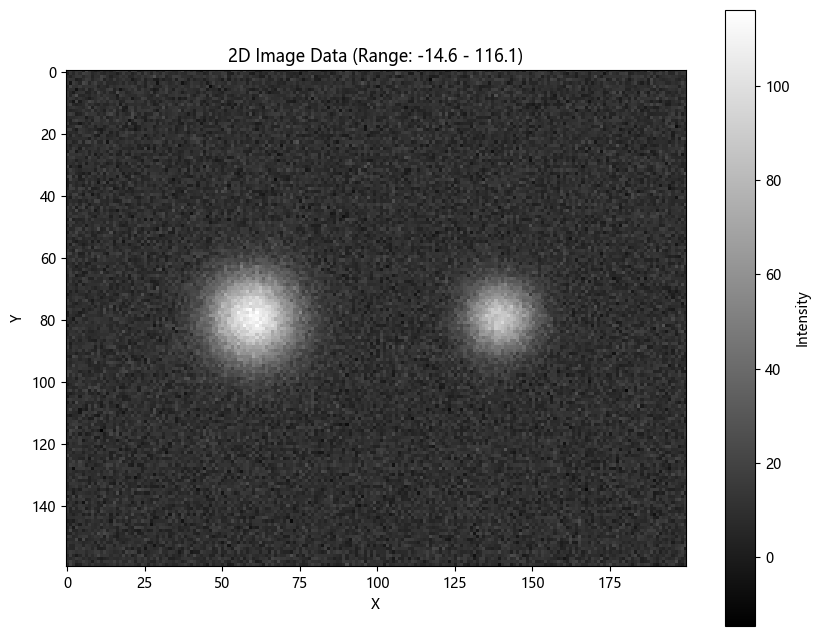


=== 调整亮度范围 ===
亮度范围已调整为: 20 - 150


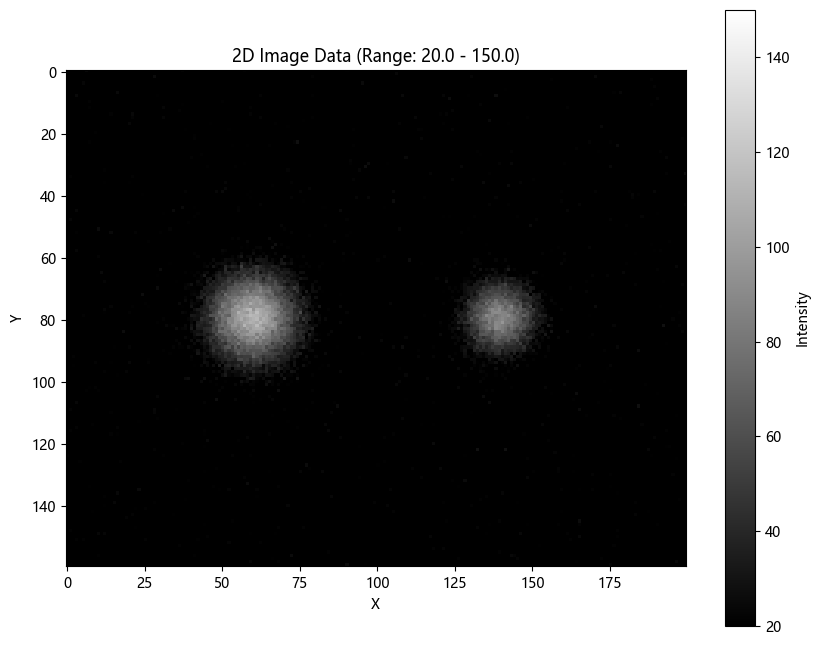


=== 保存图像 ===
图像已保存为: demo_output.png
数据已保存为CSV: demo_data.csv

=== 数据切割 ===
数据已切割为 8 个块，沿 Y 轴

=== 数据降维 ===
已对 8 个数据块沿 X 方向进行降维

=== 统计分析 ===
数据块 0 统计信息:
  均值: 10.051
  标准差: 5.022
  方差: 25.225
  范围: [-9.620, 27.471]
  偏度: -0.044
  峰度: 0.018
----------------------------------------
数据块 1 统计信息:
  均值: 9.890
  标准差: 4.994
  方差: 24.939
  范围: [-8.511, 27.866]
  偏度: 0.035
  峰度: 0.103
----------------------------------------
数据块 2 统计信息:
  均值: 10.416
  标准差: 5.094
  方差: 25.947
  范围: [-6.318, 28.055]
  偏度: 0.067
  峰度: -0.018
----------------------------------------
数据块 3 统计信息:
  均值: 21.062
  标准差: 20.913
  方差: 437.372
  范围: [-5.876, 116.145]
  偏度: 2.038
  峰度: 3.892
----------------------------------------
数据块 4 统计信息:
  均值: 21.202
  标准差: 20.742
  方差: 430.234
  范围: [-5.574, 114.748]
  偏度: 2.045
  峰度: 3.955
----------------------------------------
数据块 5 统计信息:
  均值: 10.352
  标准差: 5.217
  方差: 27.218
  范围: [-14.650, 29.112]
  偏度: 0.050
  峰度: 0.169
----------------------------------------
数据块 6 统计信息:
  均

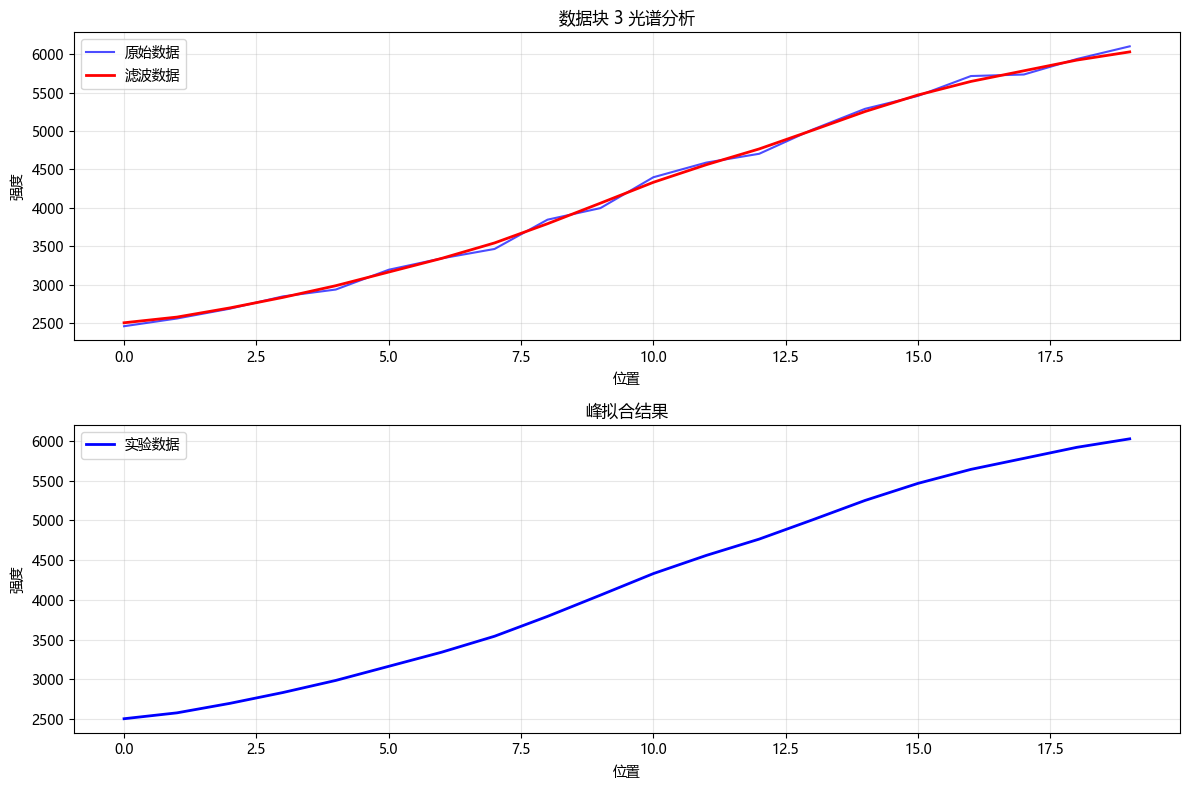


=== 容器内容 ===
容器中的数据:
  demo_spectrum.tiff: 160x200 数据

演示完成！

=== 使用示例 ===
# 读取TIFF文件
df, metadata = read_tiff_to_df('your_file.tiff')
add_data_to_container('your_file.tiff', df, metadata)

# 获取分析对象
analyzer = get_data_from_container('your_file.tiff')

# 进行分析
analyzer.visualize_data()
analyzer.slice_data('x', 0, 200, 25)
analyzer.integrate_blocks_along_dimension('y')
analyzer.spectral_analysis(0)


In [10]:
# ==================== 演示代码 ====================

def demo_analysis():
    """演示完整的数据分析流程"""
    print("=== 创建演示数据 ===")
    
    # 创建模拟的光谱图像数据
    x = np.linspace(0, 100, 200)
    y = np.linspace(0, 80, 160)
    X, Y = np.meshgrid(x, y)
    
    # 模拟多个高斯峰的光谱数据
    peak1 = 100 * np.exp(-((X-30)**2 + (Y-40)**2)/50)
    peak2 = 80 * np.exp(-((X-70)**2 + (Y-40)**2)/30)
    noise = np.random.normal(0, 5, X.shape)
    
    simulated_data = peak1 + peak2 + noise + 10
    df_demo = pd.DataFrame(simulated_data)
    
    metadata_demo = {
        'filename': 'demo_spectrum.tiff',
        'description': '模拟光谱数据',
        'peaks': ['peak1 at (30,40)', 'peak2 at (70,40)']
    }
    
    # 添加到容器
    add_data_to_container('demo_spectrum.tiff', df_demo, metadata_demo)
    
    # 获取数据对象
    analyzer = get_data_from_container('demo_spectrum.tiff')
    
    print("\n=== 数据可视化 ===")
    analyzer.visualize_data()
    
    print("\n=== 调整亮度范围 ===")
    analyzer.adjust_brightness_range(20, 150)
    analyzer.visualize_data()
    
    print("\n=== 保存图像 ===")
    analyzer.save_as_image('demo_output.png')
    analyzer.save_as_csv('demo_data.csv')
    
    print("\n=== 数据切割 ===")
    analyzer.slice_data('y', 0, 160, 20)  # 沿Y轴切割为8块
    
    print("\n=== 数据降维 ===")
    analyzer.integrate_blocks_along_dimension('x')  # 沿X方向求和
    
    print("\n=== 统计分析 ===")
    stats = analyzer.analyze_blocks_statistics()
    
    print("\n=== 光谱分析 ===")
    # 对第4个数据块进行光谱分析
    spectral_result = analyzer.spectral_analysis(3)
    
    print("\n=== 光谱分析可视化 ===")
    analyzer.plot_spectral_analysis(3)
    
    print("\n=== 容器内容 ===")
    list_container_contents()
    
    print("\n演示完成！")

if __name__ == "__main__":
    # 运行演示
    demo_analysis()
    
    # 使用示例
    print("\n=== 使用示例 ===")
    print("# 读取TIFF文件")
    print("df, metadata = read_tiff_to_df('your_file.tiff')")
    print("add_data_to_container('your_file.tiff', df, metadata)")
    print("")
    print("# 获取分析对象")
    print("analyzer = get_data_from_container('your_file.tiff')")
    print("")
    print("# 进行分析")
    print("analyzer.visualize_data()")
    print("analyzer.slice_data('x', 0, 200, 25)")
    print("analyzer.integrate_blocks_along_dimension('y')")
    print("analyzer.spectral_analysis(0)")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Union
from scipy import ndimage, signal
from scipy.optimize import curve_fit
from scipy.stats import describe
import cv2
import warnings

# 忽略所有警告信息，这在交互式会话或脚本执行时可能有用，以减少输出干扰
warnings.filterwarnings('ignore')

# ==================== 文件读取模块 ====================
# 这一部分包含用于读取不同图像文件格式并将其转换为Pandas DataFrame的函数。

def read_tiff_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    读取TIFF文件并转换为DataFrame。
    此函数专门处理TIFF格式，并尝试提取其元数据。
    
    Args:
        filepath: TIFF文件的完整路径。
        
    Returns:
        tuple: 包含两个元素的元组：
               - pd.DataFrame: TIFF图像的像素数据，转换为灰度图后的二维DataFrame。
               - dict: 包含图像尺寸、模式、格式、文件名等元数据，以及可能的EXIF信息。
    """
    try:
        # 使用PIL (Pillow) 库打开TIFF文件
        with Image.open(filepath) as img:
            # 提取图像的基本元数据
            metadata = {
                'filename': filepath,
                'size': img.size,       # 图像的宽度和高度 (width, height)
                'mode': img.mode,       # 图像的模式 (e.g., 'L' for grayscale, 'RGB' for color)
                'format': img.format,   # 图像格式 (e.g., 'TIFF')
                'width': img.width,     # 图像宽度
                'height': img.height    # 图像高度
            }
            
            # 如果图像包含EXIF（可交换图像文件格式）信息，则将其添加到元数据中
            if hasattr(img, '_getexif') and img._getexif():
                metadata['exif'] = img._getexif()
            
            # 将PIL图像对象转换为NumPy数组，便于数值处理
            img_array = np.array(img)
            
            # 如果图像是彩色图像（通常是3个维度：高度、宽度、颜色通道），则转换为灰度图。
            # 这是因为后续的数据分析可能主要关注强度值，而不是颜色信息。
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True # 标记已转换为灰度
            
            # 将处理后的NumPy数组转换为Pandas DataFrame，每行代表图像的一行像素，每列代表一列像素。
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        # 捕获并打印读取TIFF文件时可能发生的任何错误
        print(f"读取TIFF文件失败: {e}")
        return pd.DataFrame(), {} # 返回空的DataFrame和字典以表示失败

def read_image_to_df(filepath: str) -> Tuple[pd.DataFrame, dict]:
    """
    通用图像文件读取函数，支持多种常见图像格式（如PNG, JPEG, BMP等）。
    该函数与read_tiff_to_df逻辑类似，只是不特意处理TIFF独有的EXIF。
    
    Args:
        filepath: 图像文件的完整路径。
        
    Returns:
        tuple: 包含两个元素的元组：
               - pd.DataFrame: 图像的像素数据，转换为灰度图后的二维DataFrame。
               - dict: 包含图像尺寸、模式、格式、文件名等基本元数据。
    """
    try:
        # 使用PIL (Pillow) 库打开图像文件，PIL支持多种格式
        with Image.open(filepath) as img:
            metadata = {
                'filename': filepath,
                'size': img.size,
                'mode': img.mode,
                'format': img.format,
                'width': img.width,
                'height': img.height
            }
            
            # 将PIL图像对象转换为NumPy数组
            img_array = np.array(img)
            
            # 如果图像是彩色图像，则转换为灰度图
            if len(img_array.shape) == 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
                metadata['converted_to_grayscale'] = True
            
            # 转换为DataFrame
            df = pd.DataFrame(img_array)
            
        return df, metadata
        
    except Exception as e:
        # 捕获并打印读取图像文件时可能发生的任何错误
        print(f"读取图像文件失败: {e}")
        return pd.DataFrame(), {} # 返回空的DataFrame和字典以表示失败

# ==================== 数据分析类 ====================
# DataAnalysis类封装了对2D图像数据进行可视化、切割、降维和光谱分析的功能。

@dataclass # 使用dataclass装饰器，自动生成__init__等方法，简化类的定义
class DataAnalysis:
    """
    通用2D图像数据分析类。
    
    该类提供了完整的2D DataFrame（通常是图像数据）处理和分析功能，包括：
    - 数据可视化和亮度调整：显示图像并控制其亮度范围。
    - 数据切割和降维：将2D数据切割成小块，并沿着特定轴进行求和（降维）。
    - 光谱分析：对一维数据（如降维后的数据）进行滤波、峰值检测、峰宽测量和曲线拟合。
    - 数据导出功能：将数据保存为CSV、Parquet或常见图像格式。
    
    Attributes:
        original_data (pd.DataFrame): 存储原始的2D图像数据。
        metadata (dict): 存储与数据相关的元信息，如文件名、尺寸等。
        sliced_blocks (List[pd.DataFrame]): 存储经过切割操作后的多个数据块（子DataFrame）。
        integrated_blocks (List[pd.DataFrame]): 存储经过降维处理后的数据列表，每个元素可能是一维的Series。
        spectral_results (dict): 存储光谱分析的结果，键为数据块索引，值为分析结果字典。
        brightness_range (Tuple[float, float]): 当前用于可视化的亮度范围 (最小值, 最大值)。
    """
    original_data: pd.DataFrame # 原始数据，类型为Pandas DataFrame
    metadata: dict = field(default_factory=dict) # 元数据字典，默认使用default_factory创建空字典
    sliced_blocks: List[pd.DataFrame] = field(default_factory=list) # 切割后的数据块列表，默认空列表
    integrated_blocks: List[pd.DataFrame] = field(default_factory=list) # 降维后的数据列表，默认空列表
    spectral_results: dict = field(default_factory=dict) # 光谱分析结果字典，默认空字典
    brightness_range: Tuple[float, float] = field(default_factory=lambda: (0, 255)) # 亮度范围，默认0-255

    def __post_init__(self):
        """
        dataclass的后初始化方法。
        在对象创建后自动调用，用于执行额外的初始化逻辑。
        这里用于在原始数据不为空时，根据数据自动设置初始的亮度范围。
        """
        if not self.original_data.empty:
            self.brightness_range = (
                float(self.original_data.min().min()), # 数据的全局最小值
                float(self.original_data.max().max())  # 数据的全局最大值
            )
    
    def visualize_data(self, figsize: Tuple[int, int] = (10, 8), 
                       brightness_range: Optional[Tuple[float, float]] = None) -> None:
        """
        可视化2D数据，通常用于显示图像。
        支持调整图像的显示尺寸和亮度范围。
        
        Args:
            figsize: 图像的尺寸，一个包含宽度和高度的元组 (width, height)。
            brightness_range: 可选参数，用于指定显示时数据的亮度范围 (min, max)。
                              如果为None，则使用实例当前存储的brightness_range。
        """
        if self.original_data.empty:
            print("没有数据可视化")
            return
        
        # 如果提供了新的亮度范围，则更新实例的亮度范围
        if brightness_range:
            self.brightness_range = brightness_range
        
        plt.figure(figsize=figsize) # 创建一个新的Matplotlib图
        # 使用imshow显示2D数据，cmap='gray'表示灰度图，vmin和vmax控制颜色映射的亮度范围
        plt.imshow(self.original_data.values, 
                   cmap='gray', 
                   vmin=self.brightness_range[0], 
                   vmax=self.brightness_range[1])
        plt.colorbar(label='Intensity') # 添加颜色条，显示强度对应关系
        plt.title(f'2D Image Data (Range: {self.brightness_range[0]:.1f} - {self.brightness_range[1]:.1f})')
        plt.xlabel('X') # X轴标签
        plt.ylabel('Y') # Y轴标签
        plt.show() # 显示图像
    
    def adjust_brightness_range(self, min_val: float, max_val: float) -> None:
        """
        调整图像可视化时的亮度范围。
        这个调整只会影响visualize_data和save_as_image的显示/保存效果，不改变原始数据。
        
        Args:
            min_val: 最小亮度值。
            max_val: 最大亮度值。
        """
        self.brightness_range = (min_val, max_val)
        print(f"亮度范围已调整为: {min_val} - {max_val}")
    
    def save_as_image(self, filepath: str, format: str = 'PNG') -> None:
        """
        将当前亮度设置下的数据保存为标准图像格式（PNG, JPEG, TIFF等）。
        数据会根据当前的亮度范围进行归一化到0-255，然后保存为8位灰度图像。
        
        Args:
            filepath: 图像文件的保存路径（包括文件名和扩展名）。
            format: 图像的保存格式，例如 'PNG', 'JPEG', 'TIFF'。
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        # 创建数据的副本，避免修改原始数据
        data = self.original_data.values.copy()
        # 将数据裁剪到当前的亮度范围内，超出范围的值会被截断
        data = np.clip(data, self.brightness_range[0], self.brightness_range[1])
        # 将裁剪后的数据归一化到0-255的范围，并转换为8位无符号整数类型 (np.uint8)
        data = ((data - self.brightness_range[0]) / 
                (self.brightness_range[1] - self.brightness_range[0]) * 255).astype(np.uint8)
        
        # 从NumPy数组创建PIL图像对象，mode='L'表示8位灰度图
        img = Image.fromarray(data, mode='L')
        # 保存图像到指定路径和格式
        img.save(filepath, format=format)
        print(f"图像已保存为: {filepath}")
    
    def save_as_csv(self, filepath: str) -> None:
        """
        将原始DataFrame数据保存为CSV文件。
        
        Args:
            filepath: CSV文件的保存路径。
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        # 使用Pandas的to_csv方法保存DataFrame，index=False表示不写入行索引
        self.original_data.to_csv(filepath, index=False)
        print(f"数据已保存为CSV: {filepath}")
    
    def save_as_parquet(self, filepath: str) -> None:
        """
        将原始DataFrame数据保存为Parquet格式。
        Parquet是一种列式存储格式，通常推荐用于大数据存储，因为它压缩效率高，读取速度快。
        需要安装pyarrow或fastparquet库。
        
        Args:
            filepath: Parquet文件的保存路径。
        """
        if self.original_data.empty:
            print("没有数据可保存")
            return
        
        try:
            # 使用Pandas的to_parquet方法保存DataFrame
            self.original_data.to_parquet(filepath, index=False)
            print(f"数据已保存为Parquet: {filepath}")
        except ImportError:
            # 如果没有安装必要的库，则提示用户安装
            print("需要安装pyarrow或fastparquet来保存Parquet格式")
            print("可以使用: pip install pyarrow")
    
    def slice_data(self, axis: str, start: int, end: int, step: int) -> None:
        """
        将2D数据沿指定轴切割成多个数据块（子DataFrame）。
        这些数据块会存储在sliced_blocks列表中。
        
        Args:
            axis: 切割的轴，可以是 'x' (沿列方向切割) 或 'y' (沿行方向切割)。
            start: 切割的起始坐标（包含）。
            end: 切割的结束坐标（不包含）。
            step: 每个数据块的长度或宽度。
        """
        if self.original_data.empty:
            print("没有数据可切割")
            return
        
        self.sliced_blocks.clear() # 清空之前切割的数据块
        
        if axis.lower() == 'x':
            # 沿X轴切割（按列切割）。
            # 例如，如果原始数据是图片，这相当于从左到右取垂直条带。
            for i in range(start, end, step):
                # 确保切割范围不超过原始数据的列数
                if i + step <= self.original_data.shape[1]:
                    block = self.original_data.iloc[:, i:i+step].copy() # 使用iloc进行基于位置的切片
                    self.sliced_blocks.append(block)
        elif axis.lower() == 'y':
            # 沿Y轴切割（按行切割）。
            # 例如，如果原始数据是图片，这相当于从上到下取水平条带。
            for i in range(start, end, step):
                # 确保切割范围不超过原始数据的行数
                if i + step <= self.original_data.shape[0]:
                    block = self.original_data.iloc[i:i+step, :].copy() # 使用iloc进行基于位置的切片
                    self.sliced_blocks.append(block)
        else:
            print("轴参数错误，请使用 'x' 或 'y'")
            return
        
        print(f"数据已切割为 {len(self.sliced_blocks)} 个块，沿 {axis.upper()} 轴")
    
    def integrate_blocks_along_dimension(self, direction: str) -> None:
        """
        对切割后的数据块进行降维处理，通常是求和。
        例如，如果每个数据块是二维的图像切片，沿 'x' 方向求和会将每行像素值相加，
        得到一个一维的“平均光谱”或“行强度分布”。
        
        Args:
            direction: 降维的方向，可以是 'x' (沿列求和) 或 'y' (沿行求和)。
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可处理")
            return
        
        self.integrated_blocks.clear() # 清空之前降维的数据
        
        for i, block in enumerate(self.sliced_blocks):
            if direction.lower() == 'x':
                # 沿X轴求和（对每一行求和），结果是每行的总和
                integrated = block.sum(axis=1)
            elif direction.lower() == 'y':
                # 沿Y轴求和（对每一列求和），结果是每列的总和
                integrated = block.sum(axis=0)
            else:
                print("方向参数错误，请使用 'x' 或 'y'")
                return
            
            self.integrated_blocks.append(integrated) # 将降维结果添加到列表中
        
        print(f"已对 {len(self.integrated_blocks)} 个数据块沿 {direction.upper()} 方向进行降维")
    
    def analyze_blocks_statistics(self) -> Dict[int, dict]:
        """
        对切割后的数据块进行统计分析，计算每个块的均值、方差、标准差、最小值、最大值、偏度和峰度。
        
        Returns:
            dict: 一个字典，键是数据块的索引，值是包含该数据块统计信息的新字典。
        """
        if not self.sliced_blocks:
            print("没有切割的数据块可分析")
            return {}
        
        stats_results = {} # 用于存储所有数据块的统计结果
        
        for i, block in enumerate(self.sliced_blocks):
            data = block.values.flatten() # 将数据块转换为一维数组，以便进行统计分析
            stats = describe(data) # 使用scipy.stats.describe获取数据的描述性统计信息
            
            stats_info = {
                'mean': float(stats.mean),
                'variance': float(stats.variance),
                'std': float(np.sqrt(stats.variance)), # 标准差是方差的平方根
                'min': float(stats.minmax[0]),
                'max': float(stats.minmax[1]),
                'skewness': float(stats.skewness),
                'kurtosis': float(stats.kurtosis),
                'size': int(stats.nobs) # 观察值数量
            }
            
            stats_results[i] = stats_info # 将统计结果存储到字典中
            
            # 打印每个数据块的统计信息，方便查看
            print(f"数据块 {i} 统计信息:")
            print(f"   均值: {stats_info['mean']:.3f}")
            print(f"   标准差: {stats_info['std']:.3f}")
            print(f"   方差: {stats_info['variance']:.3f}")
            print(f"   范围: [{stats_info['min']:.3f}, {stats_info['max']:.3f}]")
            print(f"   偏度: {stats_info['skewness']:.3f}")
            print(f"   峰度: {stats_info['kurtosis']:.3f}")
            print("-" * 40)
        
        return stats_results
    
    def _gaussian_func(self, x: np.ndarray, amplitude: float, center: float, sigma: float) -> np.ndarray:
        """
        私有方法：高斯函数定义。
        用于后续的曲线拟合。
        
        Args:
            x: 输入的自变量数组。
            amplitude: 高斯曲线的峰值高度。
            center: 高斯曲线的中心位置。
            sigma: 高斯曲线的标准差，与峰的宽度相关。
            
        Returns:
            np.ndarray: 计算出的高斯函数值。
        """
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))
    
    def _lorentzian_func(self, x: np.ndarray, amplitude: float, center: float, gamma: float) -> np.ndarray:
        """
        私有方法：洛伦兹函数定义。
        用于后续的曲线拟合。洛伦兹峰在光谱学中常见。
        
        Args:
            x: 输入的自变量数组。
            amplitude: 洛伦兹曲线的峰值高度。
            center: 洛伦兹曲线的中心位置。
            gamma: 洛伦兹曲线的半宽半高（HWHM）参数，FWHM是其两倍。
            
        Returns:
            np.ndarray: 计算出的洛伦兹函数值。
        """
        return amplitude * gamma**2 / ((x - center)**2 + gamma**2)
    
    def spectral_analysis(self, block_index: int, use_integrated: bool = True) -> Dict[str, any]:
        """
        对指定数据块进行光谱分析。
        这包括噪声滤波、峰值检测、峰宽（FWHM和1/e宽度）测量、高斯和洛伦兹拟合，以及信噪比计算。
        
        Args:
            block_index: 要分析的数据块的索引。
            use_integrated: 布尔值，如果为True，则使用降维后的数据（integrated_blocks）进行分析；
                            否则，如果存在切割的数据块（sliced_blocks），则对其进行平均后分析。
            
        Returns:
            dict: 包含光谱分析结果的字典，包括原始数据、滤波数据、峰信息、信噪比等。
        """
        data = None
        if use_integrated and self.integrated_blocks:
            if block_index >= len(self.integrated_blocks):
                print(f"索引超出范围，共有 {len(self.integrated_blocks)} 个降维数据块")
                return {}
            data = self.integrated_blocks[block_index].values # 获取降维数据
        elif self.sliced_blocks:
            if block_index >= len(self.sliced_blocks):
                print(f"索引超出范围，共有 {len(self.sliced_blocks)} 个数据块")
                return {}
            # 对2D数据块沿行方向取平均，得到一维光谱
            data = self.sliced_blocks[block_index].mean(axis=1).values
        else:
            print("没有可用的数据块进行光谱分析")
            return {}
        
        x = np.arange(len(data)) # 创建与数据长度相同的X轴坐标

        # 1. 噪声滤波（高斯滤波）
        # 使用一维高斯滤波器平滑数据，减少噪声，使峰值更明显。sigma控制平滑程度。
        filtered_data = ndimage.gaussian_filter1d(data, sigma=1.0)
        
        # 2. 峰值检测
        # 使用scipy.signal.find_peaks函数检测平滑数据中的峰。
        # height参数设置了峰的最小高度阈值（这里是最大值的10%），distance设置了两个峰之间的最小距离。
        peaks, properties = signal.find_peaks(filtered_data, 
                                             height=np.max(filtered_data) * 0.1, # 峰的最小高度
                                             distance=5) # 峰之间的最小水平距离
        
        # 3. 峰宽测量和拟合
        peak_results = [] # 存储每个检测到的峰的详细分析结果
        
        for peak_idx in peaks:
            peak_pos = peak_idx # 峰的X轴位置
            peak_height = filtered_data[peak_idx] # 峰的强度/高度
            
            # 计算半高全宽（FWHM - Full Width at Half Maximum）
            half_max = peak_height / 2 # 半高值
            # 找到峰左侧第一个小于等于半高值的索引
            left_idx = np.where(filtered_data[:peak_idx] <= half_max)[0]
            # 找到峰右侧第一个小于等于半高值的索引（相对峰顶的偏移量）
            right_idx = np.where(filtered_data[peak_idx:] <= half_max)[0]
            
            if len(left_idx) > 0 and len(right_idx) > 0:
                # FWHM = 右侧索引（相对于峰顶）+ (峰顶索引 - 左侧索引)
                fwhm = right_idx[0] + (peak_idx - left_idx[-1])
            else:
                fwhm = np.nan # 如果无法找到，则FWHM为NaN
            
            # 计算1/e宽度 (Width at 1/e of Maximum)
            e_height = peak_height / np.e # 1/e高值
            left_e_idx = np.where(filtered_data[:peak_idx] <= e_height)[0]
            right_e_idx = np.where(filtered_data[peak_idx:] <= e_height)[0]
            
            if len(left_e_idx) > 0 and len(right_e_idx) > 0:
                e_width = right_e_idx[0] + (peak_idx - left_e_idx[-1])
            else:
                e_width = np.nan
            
            # 高斯拟合
            gauss_fit = None # 默认为None，如果拟合失败则保持None
            try:
                # 选择峰周围的一定范围数据进行拟合，以提高拟合精度
                fit_range = 20 # 拟合范围，峰左右各20个点
                x_fit = x[max(0, peak_idx-fit_range):min(len(x), peak_idx+fit_range)]
                y_fit = filtered_data[max(0, peak_idx-fit_range):min(len(x), peak_idx+fit_range)]
                
                if len(x_fit) > 5:  # 确保有足够的数据点进行拟合
                    # 使用scipy.optimize.curve_fit进行非线性最小二乘拟合
                    # p0是初始猜测参数：[振幅, 中心位置, sigma]
                    popt_gauss, _ = curve_fit(self._gaussian_func, x_fit, y_fit,
                                              p0=[peak_height, peak_pos, fwhm/2.355 if not np.isnan(fwhm) else 1])
                    gauss_fit = {
                        'amplitude': popt_gauss[0],
                        'center': popt_gauss[1],
                        'sigma': popt_gauss[2],
                        'fwhm_fit': 2.355 * popt_gauss[2] # 高斯函数的FWHM = 2 * sqrt(2 * ln(2)) * sigma 约等于 2.355 * sigma
                    }
                else:
                    gauss_fit = None # 数据点不足，无法拟合
            except Exception as e:
                # 捕获拟合过程中可能出现的错误（如无法收敛），并设置为None
                # print(f"高斯拟合失败: {e}") # 可以选择打印错误信息进行调试
                gauss_fit = None
            
            # 洛伦兹拟合
            lorentz_fit = None # 默认为None
            try:
                if len(x_fit) > 5:
                    # p0是初始猜测参数：[振幅, 中心位置, gamma]
                    popt_lorentz, _ = curve_fit(self._lorentzian_func, x_fit, y_fit,
                                                p0=[peak_height, peak_pos, fwhm/2 if not np.isnan(fwhm) else 1])
                    lorentz_fit = {
                        'amplitude': popt_lorentz[0],
                        'center': popt_lorentz[1],
                        'gamma': popt_lorentz[2],
                        'fwhm_fit': 2 * popt_lorentz[2] # 洛伦兹函数的FWHM = 2 * gamma
                    }
                else:
                    lorentz_fit = None
            except Exception as e:
                # print(f"洛伦兹拟合失败: {e}")
                lorentz_fit = None
            
            # 峰面积计算（梯形积分）
            # 面积计算通常在峰的FWHM范围内进行，可以更准确地反映峰的“大小”。
            peak_area = np.nan
            if not np.isnan(fwhm):
                # 定义积分范围，以FWHM为基准
                area_start = max(0, int(peak_idx - fwhm/2)) # 从峰中心减去半FWHM开始
                area_end = min(len(filtered_data), int(peak_idx + fwhm/2)) # 到峰中心加上半FWHM结束
                if area_start < area_end: # 确保有效范围
                    peak_area = np.trapz(filtered_data[area_start:area_end], x[area_start:area_end]) # 使用梯形积分
            
            # 收集当前峰的所有分析结果
            peak_info = {
                'position': peak_pos,
                'height': peak_height,
                'fwhm': fwhm,
                'e_width': e_width,
                'area': peak_area,
                'gaussian_fit': gauss_fit,
                'lorentzian_fit': lorentz_fit
            }
            
            peak_results.append(peak_info)
        
        # 4. 信噪比（SNR - Signal-to-Noise Ratio）计算
        # 信号功率通常用滤波后的数据平方的均值表示，噪声功率用原始数据与滤波数据差值的平方均值表示。
        signal_power = np.mean(filtered_data**2)
        noise_power = np.mean((data - filtered_data)**2)
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf # dB表示
        
        # 整理所有光谱分析结果到一个字典中
        analysis_result = {
            'original_data': data,
            'filtered_data': filtered_data,
            'peaks': peak_results,
            'snr_db': snr,
            'total_peaks': len(peaks),
            'x_axis': x
        }
        
        # 将结果保存到实例的spectral_results字典中
        self.spectral_results[block_index] = analysis_result
        
        # 打印分析结果摘要
        print(f"\n=== 数据块 {block_index} 光谱分析结果 ===")
        print(f"检测到峰数量: {len(peaks)}")
        print(f"信噪比: {snr:.2f} dB")
        print("\n峰详细信息:")
        
        for i, peak in enumerate(peak_results):
            print(f"峰 {i+1}:")
            print(f"   位置: {peak['position']}")
            print(f"   高度: {peak['height']:.3f}")
            print(f"   FWHM: {peak['fwhm']:.3f}")
            print(f"   1/e宽度: {peak['e_width']:.3f}")
            print(f"   面积: {peak['area']:.3f}")
            
            if peak['gaussian_fit']:
                print(f"   高斯拟合中心: {peak['gaussian_fit']['center']:.3f}")
                print(f"   高斯拟合FWHM: {peak['gaussian_fit']['fwhm_fit']:.3f}")
            
            if peak['lorentzian_fit']:
                print(f"   洛伦兹拟合中心: {peak['lorentzian_fit']['center']:.3f}")
                print(f"   洛伦兹拟合FWHM: {peak['lorentzian_fit']['fwhm_fit']:.3f}")
            
            print("-" * 30)
        
        return analysis_result
    
    def plot_spectral_analysis(self, block_index: int) -> None:
        """
        绘制指定数据块的光谱分析结果，包括原始数据、滤波数据、检测到的峰以及高斯/洛伦兹拟合曲线。
        
        Args:
            block_index: 要绘制的数据块的索引。
        """
        # 检查是否已对该数据块进行光谱分析
        if block_index not in self.spectral_results:
            print("请先进行光谱分析")
            return
        
        result = self.spectral_results[block_index] # 获取分析结果
        
        plt.figure(figsize=(12, 8)) # 创建图表
        
        # 子图1：原始数据和滤波数据，并标记检测到的峰
        plt.subplot(2, 1, 1) # 2行1列的第一个子图
        plt.plot(result['x_axis'], result['original_data'], 'b-', alpha=0.7, label='原始数据')
        plt.plot(result['x_axis'], result['filtered_data'], 'r-', linewidth=2, label='滤波数据')
        
        # 标记峰位置
        for peak in result['peaks']:
            plt.axvline(x=peak['position'], color='g', linestyle='--', alpha=0.7) # 绘制垂直线表示峰位置
            plt.plot(peak['position'], peak['height'], 'ro', markersize=8) # 在峰顶绘制红点
        
        plt.xlabel('位置')
        plt.ylabel('强度')
        plt.title(f'数据块 {block_index} 光谱分析')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 子图2：拟合结果
        plt.subplot(2, 1, 2) # 2行1列的第二个子图
        plt.plot(result['x_axis'], result['filtered_data'], 'b-', linewidth=2, label='实验数据')
        
        # 绘制拟合曲线
        for i, peak in enumerate(result['peaks']):
            if peak['gaussian_fit']:
                fit_x = result['x_axis']
                # 使用拟合参数计算高斯拟合曲线
                gauss_y = self._gaussian_func(fit_x, 
                                              peak['gaussian_fit']['amplitude'],
                                              peak['gaussian_fit']['center'],
                                              peak['gaussian_fit']['sigma'])
                plt.plot(fit_x, gauss_y, '--', alpha=0.8, label=f'高斯拟合 {i+1}')
            
            # 洛伦兹拟合曲线也可以类似地添加，如果需要的话可以取消注释以下部分
            # if peak['lorentzian_fit']:
            #     fit_x = result['x_axis']
            #     lorentz_y = self._lorentzian_func(fit_x,
            #                                       peak['lorentzian_fit']['amplitude'],
            #                                       peak['lorentzian_fit']['center'],
            #                                       peak['lorentzian_fit']['gamma'])
            #     plt.plot(fit_x, lorentz_y, ':', alpha=0.8, label=f'洛伦兹拟合 {i+1}')
        
        plt.xlabel('位置')
        plt.ylabel('强度')
        plt.title('峰拟合结果')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout() # 自动调整子图参数，使之填充整个图像区域
        plt.show() # 显示图表

# ==================== 全局容器 ====================
# 这部分定义了一个全局字典，用于存储和管理多个DataAnalysis实例，
# 方便在程序的各个部分访问不同的数据集。

# 全局数据容器，字典的键是文件名（字符串），值是DataAnalysis类的实例
data_container: Dict[str, DataAnalysis] = {}

def add_data_to_container(filename: str, df: pd.DataFrame, metadata: dict = None) -> None:
    """
    将数据（DataFrame和元数据）封装成DataAnalysis对象，并添加到全局容器中。
    
    Args:
        filename: 用作容器中数据唯一标识的键，通常是文件的名称。
        df: 要添加的Pandas DataFrame数据。
        metadata: 可选的元数据字典，如果未提供则默认为空字典。
    """
    if metadata is None:
        metadata = {}
    
    # 创建DataAnalysis实例并存储到全局容器中
    data_container[filename] = DataAnalysis(original_data=df, metadata=metadata)
    print(f"数据 '{filename}' 已添加到容器中")

def get_data_from_container(filename: str) -> Optional[DataAnalysis]:
    """
    从全局容器中获取指定文件名的DataAnalysis对象。
    
    Args:
        filename: 要检索的数据的文件名（键）。
        
    Returns:
        DataAnalysis对象: 如果找到对应的文件。
        None: 如果容器中不存在该文件。
    """
    return data_container.get(filename) # 使用字典的.get()方法，如果键不存在则返回None

def list_container_contents() -> None:
    """列出全局容器中所有已加载的数据的名称和其原始数据的形状。"""
    print("容器中的数据:")
    if not data_container:
        print("   (容器为空)")
        return

    for filename, data_obj in data_container.items():
        shape = data_obj.original_data.shape # 获取原始数据的行数和列数
        print(f"   {filename}: {shape[0]}x{shape[1]} 数据")